# 21M.387 Fundamentals of Music Processing
## Problem Set 4: Chromagrams and DTW

Make sure all your answers and plots display when the code block is run. You can leave word-based answers in code comments or markdown cells.

You may use any fmplib functions from __previous__ units in your answers. You may __not__ use any fmplib functions from the current unit in your answers (unless explicitly noted). But you can use the current unit's fmplib for testing your code.

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import IPython.display as ipd
from ipywidgets import interact
import sys
sys.path.append("..")
import fmplib as fmp

plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['image.interpolation'] = 'nearest'
fmp.documentation_button()

## Exercise 1

Given the STFT $\mathcal{X}[n,k]$, we create the spectrogram $\vert \mathcal{X}[n,k] \vert^2$ and represent it as the matrix $\mathbf{X}$.

We can use the conversion matrix $\mathbf{C}_{fp}$ to create the pitch-o-gram (log-frequency spectrogram) $\mathbf{P} = \mathbf{C}_{fp} \cdot \mathbf{X}$.

Write python function `spec_to_pitch_mtx()` that computes and returns the matrix $\mathbf{C}_{fp}$, but unlike lecture, where we used a pitch range of $[0:128)$, make the function more general, providing a starting and ending pitch value. 

Inputs:
- `fs`: $F_s$, the sampling frequency
- `fft_len`: $N$, the length of DFT 
- `start_pitch`: first pitch to consider
- `end_pitch`: one after the last pitch to consider. Total number of pitches should be `end_pitch - start_pitch`

Returns:
- a matrix that, when multiplied by a spectrogram, will produce a pitch-o-gram with `end_pitch - start_pitch` rows

Assume that the spectrogram was created with a window of length $N$ and that the number of bins of the spectrogram is therefore $N/2 + 1$.

In [119]:
def freq_to_bin(f, fs, N):
    return int(f * N / fs)


def bins_of_pitch(p, fs, fft_len): 
    bin_lower = freq_to_bin(fmp.pitch_to_freq(p - 0.5), fs, fft_len)
    bin_upper = freq_to_bin(fmp.pitch_to_freq(p + 0.5), fs, fft_len)
    
    return range(int(np.ceil(bin_lower)), int(np.floor(bin_upper)))


def spec_to_pitch_mtx(fs, fft_len, start_pitch, end_pitch):
    # pitch -> bins
    p_bins = {p: bins_of_pitch(p, fs, fft_len) for p in range(start_pitch, end_pitch)}
    
    n_rows = end_pitch - start_pitch
    n_cols = int(fft_len / 2.0) + 1
    
    out = []
    for p in p_bins:
        out += [[1 if k in p_bins[p] else 0 for k in range(n_cols)]]
    return np.array(out)

Create this matrix using a pitch range of $[C2:C8)$, so that the resulting $\mathbf{P}$ will have 72 rows (spanning 6 octaves). Use $F_s = 22050$ and $N=4096$.

- Call the matrix `c_fp`
- Visualize it with `plt.imshow`

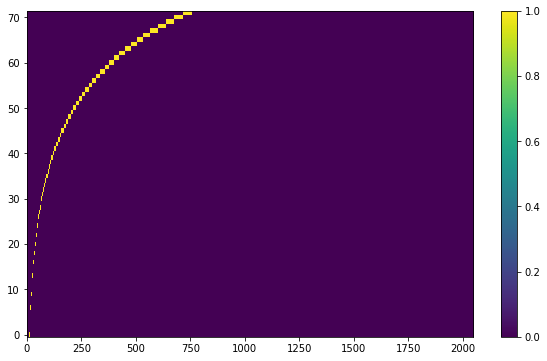

In [120]:
# fill in and plot
fs = 22050
N = 4096
C2 = 36
C8 = 108

# fmp_c_fp = fmp.spec_to_pitch_mtx(fs, N)
# plt.imshow(fmp_c_fp, origin='lower',aspect='auto')
# plt.colorbar()
# plt.show()

c_fp = spec_to_pitch_mtx(fs, N, C2, C8)
plt.imshow(c_fp, origin='lower',aspect='auto')
plt.colorbar()
plt.show()

Finally, create the pitch-o-gram for the sound file below
- Load the sound file of a piano playing two octaves of a c major scale
- Create its Spectrogram with $N=4096$ and $H=N/2$. You may use `fmp.stft(x, fft_len, hop_size)` to create the STFT
- Create the pitch-o-gram using the your function. Name this matrix `pgram`
- Plot the result using the function `fmp.plot_spectrogram(pgram)` (this plots a matrix with amplitude values on a log scale so it is easier to see small values)

Note: Since the $\mathbf{C}_{fp}$ that you made is of a smaller range, you should notice that row 0 of the pitch-o-gram corresponds to midi note 36.

In [83]:
snd1 = fmp.load_wav('audio/piano_c_scale.wav')
fs = 22050.
ipd.Audio(snd1, rate=fs)

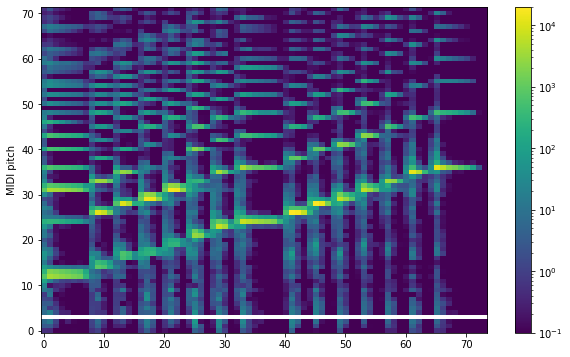

In [207]:
# fill in and plot
N = 4096
H = int(N/2)
c_fp = spec_to_pitch_mtx(fs, N, C2, C8)

spec = fmp.stft_mag(snd1, N, H) ** 2  
pgram = np.dot(c_fp, spec)
fmp.plot_spectrogram(pgram)
plt.ylabel('MIDI pitch')
plt.show()


## Exercise 2

Write the function `make_chromagram(spec, fs)` that calculates and returns a chromagram from a spectrogram.

Inputs:
- `spec`: the spectrogram matrix
- `fs`: $F_s$: the sampling rate of the original audio

Output:
- the chromagram matrix


Notes:
- Use the function `spec_to_pitch_mtx()` that you wrote above with pitch values $[0,128)$
- You will need to sum the energies for each of the 12 pitch classes. You can do that in a loop, or by creating the conversion matrix $\mathbf{C}_{pc}$
- Hint: the DFT length $N$ is needed, but does not need to be passed into the function

In [208]:
def make_chromagram(spec, fs):
    N = spec.shape[0]
    fft_len = (N - 1) * 2
    c_fp = spec_to_pitch_mtx(fs, fft_len, 0, 128)
    n_pitch = c_fp.shape[0]
    
    # "chroma" class notes 
    c_pc = np.tile(np.identity(12), 11)[:, 0:128]

    # v1: two conversion matrices 
    # pgram = np.dot(c_fp, spec)
    # cgram = np.dot(c_pc, pgram)   
    # return cgram

    # v2: combined conversion matrix
    c_fc = np.dot(c_pc, c_fp)
    return np.dot(c_fc, spec)

Make and plot the chromagram for the same audio as above.
- Name the matrix `chroma`.
- Plot it using `fmp.plot_spectrogram`.

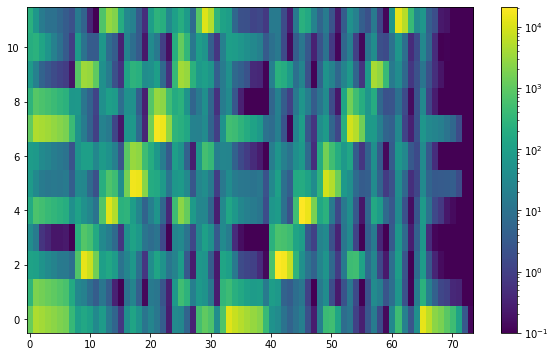

In [217]:
# create chroma and plot it
chroma = make_chromagram(spec, fs)
fmp.plot_spectrogram(chroma)
plt.show()

## Exercise 3a

It is often helpful to apply logarithmic compression to a chromagram using the function:

$\Gamma_\gamma(v) = \log_{10}(1+ \gamma \cdot v)$

- $v$ is the value to compress
- $\gamma$ is the compression factor

Create and plot the log-compressed chromagram of the audio in _Exercise 2_ 
- Name it `log_chroma`
- Use $\gamma = 10$
- Plot with `plt.imshow`


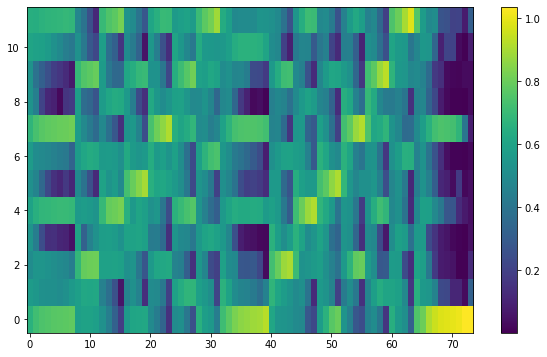

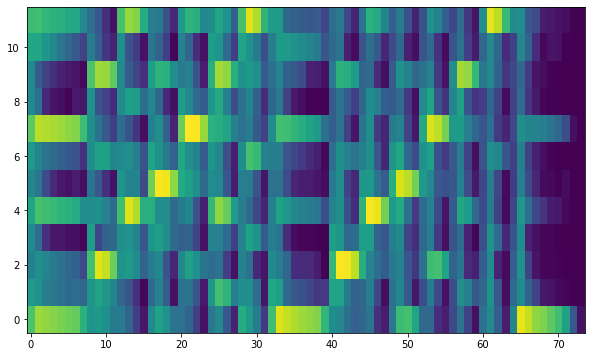

In [237]:
def log_compress(v, gamma):
    return np.log10(1 + gamma * v)

#log_chroma = log_compress(chroma, 0.001)
log_chroma = log_compress(chroma, 10)
plt.imshow(log_chroma, origin='lower', aspect='auto')
plt.colorbar()
plt.show()

# vs fmp
# chroma = fmp.make_chromagram(snd1, fs, N, N // 2, normalize=False, gamma=10)
# plt.imshow(chroma, origin='lower', aspect='auto')
# plt.show()

## Exercise 3b

It is also useful to normalize a chromagram so that each column vector is length 1.

Create and plot the normalized version of the log-compressed chromagram from _Exercise 3a_.
- Name it `norm_chroma`
- Plot with `plt.imshow`

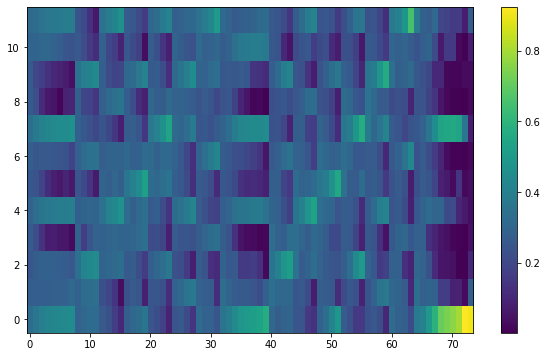

In [238]:
def normalize(v):
    L2 = np.linalg.norm(v, axis=0)
    return v/L2

norm_chroma = normalize(log_chroma)

plt.imshow(norm_chroma, origin='lower', aspect='auto')
plt.colorbar()
plt.show()

# vs fmp
# chroma = fmp.make_chromagram(snd1, fs, N, N // 2, normalize=True, gamma=10)
# plt.imshow(chroma, origin='lower', aspect='auto')
# plt.show()

## Exercise 4

In this exercise, you will apply the dynamic time warping algorithm by hand to a toy example. Given the following sequences:

$X = (2, 5, 3, 6)$  
$Y = (1, 6, 3, 4, 6, 7)$

Use the cost function of $c = \lvert x - y \rvert$ to create (by hand) the $4 \times 6$ cost matrix $\mathbf{C}$.

To write in your answer, fill in the table below with the right numbers

__Caution__: We have been looking at matrices graphically, with $(1,1)$ in the bottom left. When creating matrices in this exercise, please stick to this convention.

Answer:

$\mathbf{C}=$

| x | x | x | x | x | x |
|---|---|---|---|---|---|
|   |   |   |   |   |   |
|   |   |   |   |   |   |
|   |   |   |   |   |   |
| 1 |   |   |   |   |   |


Next, create (by hand again) two matrices: The accumulated cost matrix $\mathbf{D}$, and the backtracking matrix $\mathbf{B}$.

- Use the cost matrix $\mathbf{C}$ that you created above
- Use the boundary conditions: $p_1 = (1,1)$ and $p_L = (4, 6)$ for the warping path $P = (p_1, p_2, ... p_L)$
- Use the step size condition: $\Sigma = \{(1,0), (0,1), (1,1) \}$

To formulate $\mathbf{B}$, use the following symbols in each cell:
- 'I' (capital i) to point towards a cell from the south
- '-' (minus sign) to point towards a cell from the west
- '/' (slash) to point towards a cell from the south-west
- '.' (period) to mark cell $(1,1)$, the beginning of the warping path

Answer:

$\mathbf{D}=$

| x | x | x | x | x | x |
|---|---|---|---|---|---|
|   |   |   |   |   |   |
|   |   |   |   |   |   |
|   |   |   |   |   |   |
| 1 |   |   |   |   |   |



$\mathbf{B}=$

| x | x | x | x | x | x |
|---|---|---|---|---|---|
|   |   |   |   |   |   |
|   |   |   |   |   |   |
|   |   |   |   |   |   |
| . |   |   |   |   |   |



Finally, write down the optimal warping path $P$ as a series of $(n,m)$ coordinates by following the pointers of matrix $\mathbf{B}$.

Answer:

$P= (1,1), ... $

## Exercise 5a

In this exercise, you will create the cost matrix that compares two versions of Glen Gould playing the first part of Bach's _Goldberg Variations_. Gould famously made two different recordings of this piece - one in 1955, and again in 1981.

Listen to the two recordings below.

In [ ]:
fs = 22050
snd_x = fmp.load_wav('audio/gould_bach_goldberg_1955.wav')
display(ipd.Audio(snd_x, rate=fs))

snd_y = fmp.load_wav('audio/gould_bach_goldberg_1981.wav')
display(ipd.Audio(snd_y, rate=fs))

The code below computes the basic chromagrams (it should return results similar to your own code above). It then calculates the CENS variant of the chromagrams, as explained in lecture, using a window length of 11, and a downsampling rate of 3.

In [ ]:
fft_len = 4096
hop_size = fft_len // 2
chroma_x = fmp.make_chromagram(snd_x, fs, fft_len, hop_size, normalize=False)
chroma_y = fmp.make_chromagram(snd_y, fs, fft_len, hop_size, normalize=False)

cens_x = fmp.cens(chroma_x, 11, 3)
cens_y = fmp.cens(chroma_y, 11, 3)

plt.figure()
fmp.plot_two_chromas(cens_x, cens_y)

What is the sample rate (a.k.a the feature rate $F_f$) of these CENS chromagrams based on the above parameters?

In [ ]:
# calculate and print ff
ff = None 

## Exercise 5b

Write the function `cost_matrix(x, y)` that takes two time series and returns the cost matrix using the cosine distance.

Inputs: 
- `x`:  $\mathbf{X}$, the first feature vector of length $N$
- `y`:  $\mathbf{Y}$, the second feature vector of length $M$

Returns:
- The $N \times M$ cost matrix $\mathbf{C}$, calculated using the cosine distance metric between two feature vectors


In [ ]:
# cost function. Takes two feature vectors of length N and M. Return the NxM cost matrix:
def cost_matrix(x, y):
    pass

Call this function with the CENS chromagrams above to create the cost matrix and plot it.
- Call it `cost_xy`
- Plot with `plt.imshow`

In [ ]:
# create cost_xy using the above function and plot it.
cost_xy = None

## Exercise 6

Write the function `dtw_accum_cost(C)` to compute $\mathbf{D}$, the accumulated cost matrix.

Inputs:
- `C`: $\mathbf{C}$, the cost matrix

Returns:
-  $\mathbf{D}$, the accumulated cost matrix

The steps are outlined in p 139 of the text book.
- Initialize $\mathbf{D}$ (origin, first row, first column).
- Set up two two nested `for` loops to iterate through the elements of $\mathbf{D}$ (starting with the 2nd row and 2nd column, since the first row and column are already filled in by the init step).
- Calculate and fill in the value of $\mathbf{D}$ for each cell $(n,m)$ by following the algorithm outlined in the book (that is, selecting the lowest cost from the three possible steps).

Caution: The DTW algorithm is described using unit-offset indexing. Since you are using python with 0-offset indexing, you must be careful when translating equations into code.

Finally, use your function to create $\mathbf{D}$ from `cost_xy` above and plot it.
- Name it `D`
- Plot with `plt.imshow`

In the next exercises, you will add the backtracking and path calculation.

In [ ]:
# calculate the accumulated cost based on the cost matrix cost_xy from Exercise 5.
def dtw_accum_cost(C):
    pass

# now calculate D
# D = ...

# and plot it:


## Exercise 7

Now, you will add more code to the function you just wrote to also calculate the backtracking matrix $\mathbf{B}$.

Write the function `dtw_bt()` to compute $\mathbf{B}$, the backtracking matrix.

Inputs:
- `C`: $\mathbf{C}$ the cost matrix

Returns:
-  $\mathbf{B}$, the backtracking matrix

Strategy:

- First, copy the code from Exercise 6 to the code cell below and change it's name to `dtw_bt`.
- Then, add code to create a backtracking matrix $\mathbf{B}$ (which should be the same size as $\mathbf{D}$).
- You will need to design a mapping / coding system for $\mathbf{B}$ so that each cell of $\mathbf{B}$ can either store a step-type or "point" to another location of the matrix.
- Initialize $\mathbf{B}$'s first row and column.
- Add code in the inner loop that remembers the optimal step for calculating $\mathbf{D}[n,m]$ and stores that step in $\mathbf{B}[n,m]$.
- Return $\mathbf{B}$.


In [ ]:
# replace this with the function you wrote above, and modify as needed.

def dtw_bt(C):
    pass

## Exercise 8



The final step is to calculate the optimal path from matrix $\mathbf{B}$. 

Write the function `find_path()`:

Inputs:
- `B`: $\mathbf{B}$, the backtracking matrix

Returns:
- the optimal path as an $L \times 2$ matrix, where $L$ is the length of the path.

Strategy:  
- Accumulate the path locations backwards, starting at the topmost location $(N-1, M-1)$, following the path until you reach $(0,0)$.
- You will find the function `reverse` useful for flipping the final list of points around. In other words, the returned path should go forward, starting from $(0,0)$ and ending at $(N-1, M-1)$.


- Call `dtw_bt()` to create matrix `B`
- Call `find_path()` to create the path. Call it `path`

In [ ]:
def find_path(B):
    pass

# call dtw_bt to get B and then call find_path on B to return the path
path = ...

Plot the cost matrix and the optimal path. The code below should work if your cost matrix is named `cost_xy` and the path is named `path` and is a $L \times 2$ matrix.

In [ ]:
plt.figure()
plt.imshow(cost_xy, origin='lower', cmap='gray')
plt.plot(path.T[1], path.T[0], '-r');

## Exercise 9

In this exercise, you'll write code to listen to the correspondences. Write the function `find_equivalent_segment()` which, given a time span in one piece, returns the matching time span in the other piece.

Inputs:
- `t_start`: the starting time, in seconds, of the first piece
- `t_end`: the ending time, in seconds, of the first piece
- `path`: the matching path between the two pieces, as calculated from DTW
- `ff`: $F_f$, the feature rate of chromagrams used to create the matching path

Returns:
- `(ty_start, ty_end)`: the start and end times, in seconds, of the corresponding piece

After you create this function, you can test it using the code below. Play around with different values of `t1` and `t2` to hear the correspondence between the two versions of the _Goldberg Variations_.

In [ ]:
def find_equivalent_segment(t_start, t_end, path, ff):
    pass

In [ ]:
# set start and end times. Try different ones!
t1, t2 = 19, 22

# get corresponding start and end times:
t3, t4 = find_equivalent_segment(t1, t2, path, ff)

display(ipd.Audio(snd_x[int(t1*fs): int(t2*fs)], rate=fs))
display(ipd.Audio(snd_y[int(t3*fs): int(t4*fs)], rate=fs))

## Exercise 10

Find two versions of the same song or two different renditions of the same piece. Use Audacity to export 22050Hz wave files. Ideally, you can find a songs or pieces that are less than 5 minutes. 

Repeat the steps above for your songs and see what the optimal path looks like (make sure to plot the path). You can also find the equivalent segments and listen to how good the path is.

Remember to submit your wave files along with this notebook file.